In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import h5py
import sys
import glob
import functools
from capsa import HistogramWrapper, HistogramCallback, wrap, VAEWrapper
from train_dataloader import TrainingDatasetLoader
import mitdeeplearning as mdl
from tqdm import tqdm
import functools

In [2]:
class TrainingDatasetLoader(tf.keras.utils.Sequence):
    def __init__(self, data_path, batch_size):

        print("Opening {}".format(data_path))
        sys.stdout.flush()

        self.cache = h5py.File(data_path, "r")

        print("Loading data into memory...")
        sys.stdout.flush()
        self.images = self.cache["images"][:1000]
        self.labels = self.cache["labels"][:1000].astype(np.float32)
        self.image_dims = self.images.shape
        n_train_samples = self.image_dims[0]

        self.train_inds = np.random.permutation(np.arange(n_train_samples))[:1000]

        self.pos_train_inds = self.train_inds[self.labels[self.train_inds, 0] == 1.0]
        self.neg_train_inds = self.train_inds[self.labels[self.train_inds, 0] != 1.0]
        self.batch_size = batch_size

    def get_train_size(self):
        return self.train_inds.shape[0]

    def __len__(self):
        return int(np.floor(self.get_train_size() / self.batch_size))

    def __getitem__(self, index):
        selected_pos_inds = np.random.choice(
            self.pos_train_inds, size=self.batch_size // 2, replace=False
        )
        selected_neg_inds = np.random.choice(
            self.neg_train_inds, size=self.batch_size // 2, replace=False
        )
        selected_inds = np.concatenate((selected_pos_inds, selected_neg_inds))

        sorted_inds = np.sort(selected_inds)
        train_img = (self.images[sorted_inds, :, :, ::-1] / 255.0).astype(np.float32)
        train_label = self.labels[sorted_inds, ...]

        return np.array(train_img), np.array(train_label)

    def get_n_most_prob_faces(self, prob, n):
        idx = np.argsort(prob)[::-1]
        most_prob_inds = self.pos_train_inds[idx[: 10 * n : 10]]
        return (self.images[most_prob_inds, ...] / 255.0).astype(np.float32)

    def get_all_train_faces(self):
        return self.images[self.pos_train_inds]


In [3]:
n_filters = 12  # base number of convolutional filters
latent_dim = 10
"""Function to define a standard CNN model"""


def make_standard_classifier(n_outputs=1):
    Conv2D = functools.partial(
        tf.keras.layers.Conv2D, padding="same", activation="relu"
    )
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation="relu")

    inp = tf.keras.Input((64, 64, 3))
    x = Conv2D(filters=1 * n_filters, kernel_size=5, strides=2)(inp)
    x = BatchNormalization()(x)
    x = Conv2D(filters=2 * n_filters, kernel_size=5, strides=2)(inp)
    x = BatchNormalization()(x)
    x = Conv2D(filters=4 * n_filters, kernel_size=5, strides=2)(inp)
    x = BatchNormalization()(x)
    x = Conv2D(filters=6 * n_filters, kernel_size=5, strides=2)(inp)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Dense(n_outputs, activation=None, name="dense2")(x)

    return tf.keras.Model(inp, x)


def make_face_decoder_network():
    # Functionally define the different layer types we will use
    Conv2DTranspose = functools.partial(
        tf.keras.layers.Conv2DTranspose, padding="same", activation="relu"
    )
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation="relu")
    Reshape = tf.keras.layers.Reshape

    # Build the decoder network using the Sequential API
    decoder = tf.keras.Sequential(
        [
            # Transform to pre-convolutional generation
            Dense(units=4 * 4 * 6 * n_filters),  # 4x4 feature maps (with 6N occurances)
            Reshape(target_shape=(4, 4, 6 * n_filters)),
            # Upscaling convolutions (inverse of encoder)
            Conv2DTranspose(filters=4 * n_filters, kernel_size=3, strides=2),
            Conv2DTranspose(filters=2 * n_filters, kernel_size=3, strides=2),
            Conv2DTranspose(filters=1 * n_filters, kernel_size=5, strides=2),
            Conv2DTranspose(filters=3, kernel_size=5, strides=2),
        ]
    )
    decoder.build((None, latent_dim,))
    return decoder


In [4]:
standard_classifier = make_standard_classifier()
wrapped_classifier = HistogramWrapper(
    standard_classifier,
    VAEWrapper(
        standard_classifier, decoder=make_face_decoder_network(), latent_dim=latent_dim
    ),
)

# Training hyperparameters
batch_size = 32
num_epochs = 2  # keep small to run faster
learning_rate = 1e-5

data_path = tf.keras.utils.get_file(
    "train_face.h5", "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
)
dataloader = TrainingDatasetLoader(data_path, batch_size=batch_size)


wrapped_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

history = wrapped_classifier.fit(dataloader, epochs=num_epochs, batch_size=batch_size, callbacks=[HistogramCallback()])



2022-08-04 08:33:14.471916: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


{'name': 'dense2', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'dense2', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
Opening /Users/sadhanalolla/.keras/datasets/train_face.h5
Loading data into memory...


ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:
import mitdeeplearning as mdl 

test_faces = mdl.lab2.get_test_faces()
all_outs = [wrapped_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
# predictions = all_outs
predictions = [out[0] for out in all_outs]
biases = [out[1] for out in all_outs]

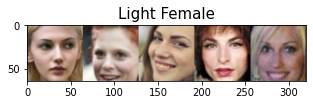

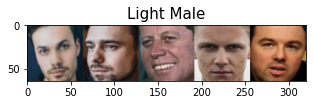

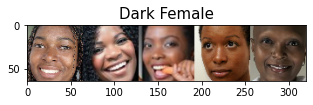

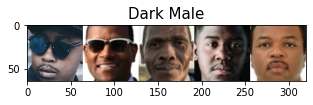

In [ ]:
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys): 
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

Text(0.5, 1.0, 'Standard classifier predictions')

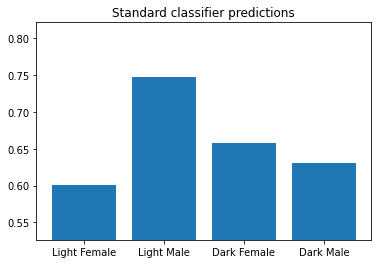

In [ ]:
# Plot the prediction accuracies per demographic
wrapped_classifier_probs = tf.squeeze(tf.sigmoid(predictions))
xx = range(len(keys))
yy = wrapped_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions")

[0. 0. 0. 0.]


/var/folders/35/1zhl0gdd2_q0zhnrdt0rjj4r0000gn/T/ipykernel_37557/2339641258.py:8: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)


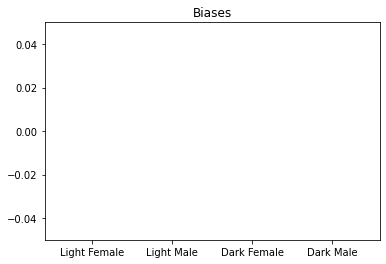

In [ ]:
biases = tf.squeeze(biases)
# Plot the biases per demographic
xx = range(len(keys))
yy = biases.numpy().mean(1)
print(yy)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Biases");

In [ ]:
print(wrapped_classifier.histogram_layer.frequencies)
all_outs = [wrapped_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
print(all_outs)


<tf.Variable 'histogram_wrapper_1/histogram_layer_1/Variable:0' shape=(5, 512) dtype=float32, numpy=
array([[9.67250e+04, 9.12990e+04, 9.92750e+04, ..., 6.84540e+04,
        1.08172e+05, 9.23850e+04],
       [1.16380e+04, 1.53110e+04, 8.05000e+03, ..., 2.08510e+04,
        1.42800e+03, 1.49570e+04],
       [1.43000e+03, 2.96700e+03, 2.19700e+03, ..., 1.56330e+04,
        2.49000e+02, 2.26300e+03],
       [9.00000e+01, 2.93000e+02, 3.29000e+02, ..., 4.28700e+03,
        3.40000e+01, 2.66000e+02],
       [5.00000e+00, 1.80000e+01, 3.70000e+01, ..., 6.63000e+02,
        5.00000e+00, 1.70000e+01]], dtype=float32)>
[(<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 15.562238 ],
       [-10.478898 ],
       [ -6.650228 ],
       [ 14.6459055],
       [ 16.404308 ]], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>), (<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[14.183405],
       [ 1.037141],
       [-6.555404],
    